# 🎙️ Fase 1: Análisis Visual de Señales Acústicas
## Proyecto Final - Dígitos Hablados (0-9)

Este notebook te permite:
- 🔍 **Comparar múltiples audios del mismo dígito** (de diferentes hablantes)
- ⚖️ **Comparar dos dígitos diferentes** 
- 📊 Visualizar señales de audio en tiempo y frecuencia
- 📈 Analizar características acústicas (FFT, Espectrograma, MFCC)
- 🎨 Gráficos profesionales y modernos

**Formato de archivos esperado:** `digito_hablante_archivo.wav` (ej: `9_03_14.wav`)

**Uso:** Ejecuta el menú principal con `menu_principal(DATA_DIR)`

---

## 📦 1. Configuración e Importación de Librerías

Instalación (si es necesario):
```bash
pip install numpy scipy librosa matplotlib pandas soundfile
```


In [1]:
# Importar librerías necesarias
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from pathlib import Path
import pandas as pd
import soundfile as sf
import random
from datetime import datetime
from IPython.display import Audio, display, Markdown
import warnings
import re
warnings.filterwarnings('ignore')

# Configuración de matplotlib para gráficos más bonitos y profesionales
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    plt.style.use('default')

# Personalización avanzada del estilo
plt.rcParams['figure.figsize'] = (15, 4)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = '#f8f9fa'
plt.rcParams['axes.edgecolor'] = '#adb5bd'
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = 'white'
plt.rcParams['grid.linewidth'] = 1.5
plt.rcParams['grid.alpha'] = 0.9
plt.rcParams['font.size'] = 11
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlepad'] = 15
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['legend.framealpha'] = 0.9
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

# Paleta de colores moderna
COLORS = {
    'primary': '#2563eb',    # Azul moderno
    'secondary': '#f97316',  # Naranja
    'success': '#10b981',    # Verde
    'danger': '#ef4444',     # Rojo
    'warning': '#f59e0b',    # Amarillo
    'info': '#06b6d4',       # Cyan
    'purple': '#8b5cf6',     # Púrpura
    'pink': '#ec4899'        # Rosa
}

print("✅ Librerías importadas correctamente")
print(f"📅 Fecha: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🎨 Estilo de gráficos: Moderno y profesional")


✅ Librerías importadas correctamente
📅 Fecha: 2025-11-04 16:55:51
🎨 Estilo de gráficos: Moderno y profesional


## 📂 2. Configuración de Rutas

Ajusta la ruta `DATA_DIR` según tu configuración:
- Ruta relativa: `data` 
- Ruta absoluta: `/ruta/completa/a/tu/carpeta/data`


In [2]:
# Configuración de rutas
DATA_DIR = Path("data")  # Carpeta con subcarpetas 01, 02, ..., 60
LOG_CSV = "labels_log.csv"

# Verificar que la carpeta existe
if DATA_DIR.exists():
    subdirs = sorted([d for d in DATA_DIR.iterdir() if d.is_dir()])
    print(f"✅ Carpeta encontrada: {DATA_DIR.absolute()}")
    print(f"📁 Subcarpetas detectadas: {len(subdirs)}")
    print(f"   Ejemplo: {subdirs[:5] if len(subdirs) >= 5 else subdirs}")
else:
    print(f"❌ ERROR: No se encontró la carpeta {DATA_DIR.absolute()}")
    print("   Ajusta la variable DATA_DIR")


✅ Carpeta encontrada: /Users/jesusmejia/google/uis/discretas/data
📁 Subcarpetas detectadas: 57
   Ejemplo: [PosixPath('data/01'), PosixPath('data/02'), PosixPath('data/03'), PosixPath('data/04'), PosixPath('data/06')]


## 🛠️ 3. Funciones de Análisis Acústico

Estas funciones calculan y visualizan las características de los audios.

**Nota:** El dígito se extrae automáticamente del nombre del archivo.
- Formato esperado: `digito_hablante_archivo.wav` (ejemplo: `9_03_14.wav` = dígito 9)


In [3]:
def extract_digit_from_filename(filename):
    """
    Extrae el dígito del nombre del archivo
    Formato esperado: digito_hablante_archivo.wav
    Ejemplo: 9_03_14.wav -> retorna 9
    
    Args:
        filename: Nombre del archivo (string o Path)
    
    Returns:
        int: Dígito extraído (0-9) o None si no se puede extraer
    """
    try:
        # Obtener solo el nombre del archivo sin la ruta
        name = Path(filename).name
        # Extraer el primer número antes del primer _
        match = re.match(r'^(\d+)_', name)
        if match:
            digit = int(match.group(1))
            if 0 <= digit <= 9:
                return digit
        return None
    except:
        return None


def extract_features(audio_path):
    """
    Extrae características acústicas de un archivo de audio
    
    Retorna:
        dict con: y (señal), sr (sample rate), duración, RMS, ZCR, centroid
    """
    # Cargar audio
    y, sr = librosa.load(audio_path, sr=None)
    
    # Características temporales
    duration = librosa.get_duration(y=y, sr=sr)
    rms = np.sqrt(np.mean(y**2))  # Root Mean Square (energía)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))  # Zero Crossing Rate
    
    # Características espectrales
    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
    centroid = np.mean(spectral_centroids)
    
    return {
        'y': y,
        'sr': sr,
        'duration': duration,
        'rms': rms,
        'zcr': zcr,
        'centroid': centroid,
        'path': str(audio_path)
    }


def plot_waveform(y, sr, title="Forma de Onda"):
    """Grafica la forma de onda en el dominio del tiempo"""
    fig, ax = plt.subplots(figsize=(15, 4))
    time = np.linspace(0, len(y)/sr, len(y))
    ax.plot(time, y, color=COLORS['primary'], linewidth=1.5, alpha=0.8)
    ax.fill_between(time, y, alpha=0.2, color=COLORS['primary'])
    ax.set_xlabel('Tiempo (s)', fontweight='bold')
    ax.set_ylabel('Amplitud', fontweight='bold')
    ax.set_title(title, pad=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()


def plot_fft(y, sr, title="Transformada de Fourier (FFT)"):
    """Grafica el espectro de frecuencias usando FFT"""
    fig, ax = plt.subplots(figsize=(15, 4))
    
    # Calcular FFT
    N = len(y)
    yf = fft(y)
    xf = fftfreq(N, 1/sr)
    
    # Solo frecuencias positivas
    positive_freqs = xf[:N//2]
    magnitude = 2.0/N * np.abs(yf[:N//2])
    
    ax.plot(positive_freqs, magnitude, color=COLORS['secondary'], linewidth=1.8, alpha=0.9)
    ax.fill_between(positive_freqs, magnitude, alpha=0.25, color=COLORS['secondary'])
    ax.set_xlabel('Frecuencia (Hz)', fontweight='bold')
    ax.set_ylabel('Magnitud', fontweight='bold')
    ax.set_title(title, pad=15)
    ax.set_xlim(0, sr//2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()


def plot_spectrogram(y, sr, title="Espectrograma (STFT)"):
    """Grafica el espectrograma (tiempo-frecuencia)"""
    fig, ax = plt.subplots(figsize=(15, 5))
    
    # Calcular espectrograma
    D = librosa.stft(y)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    
    img = librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', 
                                    cmap='inferno', ax=ax)
    cbar = plt.colorbar(img, ax=ax, format='%+2.0f dB')
    cbar.set_label('Intensidad (dB)', rotation=270, labelpad=20, fontweight='bold')
    ax.set_xlabel('Tiempo (s)', fontweight='bold')
    ax.set_ylabel('Frecuencia (Hz)', fontweight='bold')
    ax.set_title(title, pad=15)
    plt.tight_layout()
    plt.show()


def plot_mfcc(y, sr, title="Coeficientes MFCC"):
    """Grafica los coeficientes MFCC (Mel-Frequency Cepstral Coefficients)"""
    fig, ax = plt.subplots(figsize=(15, 5))
    
    # Calcular MFCC (13 coeficientes por defecto)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    
    img = librosa.display.specshow(mfccs, sr=sr, x_axis='time', 
                                    cmap='RdYlBu_r', ax=ax)
    cbar = plt.colorbar(img, ax=ax)
    cbar.set_label('Coeficiente', rotation=270, labelpad=20, fontweight='bold')
    ax.set_xlabel('Tiempo (s)', fontweight='bold')
    ax.set_ylabel('Coeficiente MFCC', fontweight='bold')
    ax.set_title(title, pad=15)
    plt.tight_layout()
    plt.show()


def analyze_audio(audio_path):
    """
    Función principal: analiza completamente un audio
    Muestra todas las visualizaciones y retorna las características
    """
    print(f"\n{'='*80}")
    print(f"🎵 Analizando: {audio_path}")
    print(f"{'='*80}\n")
    
    # Extraer características
    features = extract_features(audio_path)
    
    # Mostrar información básica
    print(f"📊 Características básicas:")
    print(f"   • Duración: {features['duration']:.3f} segundos")
    print(f"   • Sample Rate: {features['sr']} Hz")
    print(f"   • RMS (energía): {features['rms']:.6f}")
    print(f"   • Zero Crossing Rate: {features['zcr']:.6f}")
    print(f"   • Spectral Centroid: {features['centroid']:.2f} Hz")
    print()
    
    # Reproducir audio
    print("🎧 Reproduciendo audio...")
    display(Audio(features['y'], rate=features['sr']))
    print()
    
    # Visualizaciones
    print("📈 Generando visualizaciones...\n")
    
    plot_waveform(features['y'], features['sr'], 
                  f"Forma de Onda - {Path(audio_path).name}")
    
    plot_fft(features['y'], features['sr'], 
             f"FFT - {Path(audio_path).name}")
    
    plot_spectrogram(features['y'], features['sr'], 
                     f"Espectrograma - {Path(audio_path).name}")
    
    plot_mfcc(features['y'], features['sr'], 
              f"MFCC - {Path(audio_path).name}")
    
    return features

print("✅ Funciones de análisis definidas correctamente")


✅ Funciones de análisis definidas correctamente


## 🎲 4. Sistema de Selección y Etiquetado

Puedes seleccionar audios aleatoriamente o elegir una carpeta específica.


In [4]:
def get_random_audio(data_dir, folder=None):
    """
    Obtiene un archivo de audio aleatorio
    
    Args:
        data_dir: Carpeta raíz con subcarpetas de audios
        folder: (opcional) Nombre de subcarpeta específica (ej: "01", "15")
    
    Returns:
        Path al archivo de audio seleccionado
    """
    if folder:
        target_dir = data_dir / folder
        if not target_dir.exists():
            print(f"❌ La carpeta {folder} no existe")
            return None
    else:
        # Elegir carpeta aleatoria
        subdirs = [d for d in data_dir.iterdir() if d.is_dir()]
        if not subdirs:
            print(f"❌ No se encontraron subcarpetas en {data_dir}")
            return None
        target_dir = random.choice(subdirs)
    
    # Elegir archivo aleatorio
    audio_files = list(target_dir.glob("*.wav"))
    if not audio_files:
        print(f"❌ No se encontraron archivos .wav en {target_dir}")
        return None
    
    return random.choice(audio_files)


def get_random_audio_by_digit(data_dir, digit):
    """
    Obtiene un audio aleatorio de un dígito específico
    
    Args:
        data_dir: Carpeta raíz con subcarpetas de audios
        digit: Dígito a buscar (0-9)
    
    Returns:
        Path al archivo o None si no se encuentra
    """
    # Buscar en todas las subcarpetas
    subdirs = [d for d in data_dir.iterdir() if d.is_dir()]
    
    # Encontrar todos los audios que comienzan con el dígito
    matching_files = []
    for subdir in subdirs:
        files = list(subdir.glob(f"{digit}_*.wav"))
        matching_files.extend(files)
    
    if not matching_files:
        return None
    
    return random.choice(matching_files)


def compare_same_digit_multiple(data_dir, digit, num_samples=5):
    """
    Compara múltiples audios del mismo dígito de diferentes hablantes
    
    Args:
        data_dir: Carpeta raíz con subcarpetas de audios
        digit: Dígito a comparar (0-9)
        num_samples: Número de muestras a comparar (default: 5)
    """
    print(f"\n{'='*80}")
    print(f"🔍 COMPARANDO {num_samples} MUESTRAS DEL DÍGITO: {digit}")
    print(f"{'='*80}\n")
    
    # Buscar todas las carpetas (hablantes)
    subdirs = sorted([d for d in data_dir.iterdir() if d.is_dir()])
    
    # Seleccionar carpetas aleatorias
    if len(subdirs) < num_samples:
        print(f"⚠️  Solo hay {len(subdirs)} carpetas disponibles")
        num_samples = len(subdirs)
    
    selected_folders = random.sample(subdirs, num_samples)
    
    # Buscar un audio del dígito en cada carpeta
    audio_paths = []
    for folder in selected_folders:
        files = list(folder.glob(f"{digit}_*.wav"))
        if files:
            audio_paths.append(random.choice(files))
    
    if len(audio_paths) < 2:
        print(f"❌ No se encontraron suficientes audios del dígito {digit}")
        print(f"   Solo se encontraron {len(audio_paths)} audio(s)")
        return
    
    print(f"✅ Se encontraron {len(audio_paths)} audios del dígito {digit}\n")
    
    # Analizar y comparar cada audio
    for i, audio_path in enumerate(audio_paths, 1):
        print(f"\n{'─'*80}")
        print(f"📊 AUDIO {i}/{len(audio_paths)}")
        print(f"{'─'*80}")
        print(f"📁 Carpeta: {audio_path.parent.name}")
        print(f"📄 Archivo: {audio_path.name}\n")
        
        features = extract_features(audio_path)
        
        # Mostrar características
        print(f"⏱️  Duración: {features['duration']:.3f} s")
        print(f"⚡ RMS: {features['rms']:.6f}")
        print(f"🔊 ZCR: {features['zcr']:.6f}")
        print(f"🎵 Centroid: {features['centroid']:.2f} Hz")
        
        # Reproducir audio
        print(f"\n🎧 Reproduciendo...")
        display(Audio(features['y'], rate=features['sr']))
        
        # Mostrar visualizaciones
        plot_waveform(features['y'], features['sr'], 
                     f"Forma de Onda - Audio {i} - {audio_path.name}")
        
        plot_fft(features['y'], features['sr'], 
                f"FFT - Audio {i} - {audio_path.name}")
        
        plot_spectrogram(features['y'], features['sr'], 
                        f"Espectrograma - Audio {i} - {audio_path.name}")
    
    print(f"\n{'='*80}")
    print(f"✅ COMPARACIÓN COMPLETADA")
    print(f"{'='*80}\n")


def compare_two_digits(data_dir, digit1, digit2):
    """
    Compara dos audios de dígitos diferentes
    
    Args:
        data_dir: Carpeta raíz con subcarpetas de audios
        digit1: Primer dígito (0-9)
        digit2: Segundo dígito (0-9)
    """
    print(f"\n{'='*80}")
    print(f"⚖️  COMPARANDO DÍGITO {digit1} vs DÍGITO {digit2}")
    print(f"{'='*80}\n")
    
    # Obtener audios aleatorios para cada dígito
    audio1 = get_random_audio_by_digit(data_dir, digit1)
    audio2 = get_random_audio_by_digit(data_dir, digit2)
    
    if audio1 is None:
        print(f"❌ No se encontraron audios del dígito {digit1}")
        return
    
    if audio2 is None:
        print(f"❌ No se encontraron audios del dígito {digit2}")
        return
    
    print(f"✅ Audios seleccionados:")
    print(f"   Dígito {digit1}: {audio1.name} (carpeta {audio1.parent.name})")
    print(f"   Dígito {digit2}: {audio2.name} (carpeta {audio2.parent.name})\n")
    
    # Extraer características
    features1 = extract_features(audio1)
    features2 = extract_features(audio2)
    
    # Tabla comparativa
    print(f"{'─'*80}")
    print(f"📊 TABLA COMPARATIVA")
    print(f"{'─'*80}\n")
    
    comparison_data = {
        'Característica': ['Duración (s)', 'RMS', 'ZCR', 'Centroid (Hz)'],
        f'Dígito {digit1}': [
            f"{features1['duration']:.3f}",
            f"{features1['rms']:.6f}",
            f"{features1['zcr']:.6f}",
            f"{features1['centroid']:.2f}"
        ],
        f'Dígito {digit2}': [
            f"{features2['duration']:.3f}",
            f"{features2['rms']:.6f}",
            f"{features2['zcr']:.6f}",
            f"{features2['centroid']:.2f}"
        ]
    }
    df_comp = pd.DataFrame(comparison_data)
    print(df_comp.to_string(index=False))
    print()
    
    # Reproducir audios
    print(f"🎧 Audio Dígito {digit1}:")
    display(Audio(features1['y'], rate=features1['sr']))
    print(f"\n🎧 Audio Dígito {digit2}:")
    display(Audio(features2['y'], rate=features2['sr']))
    print()
    
    # Gráficas comparativas
    fig, axes = plt.subplots(2, 1, figsize=(15, 8))
    
    # Formas de onda
    time1 = np.linspace(0, features1['duration'], len(features1['y']))
    time2 = np.linspace(0, features2['duration'], len(features2['y']))
    
    axes[0].plot(time1, features1['y'], label=f'Dígito {digit1}', 
                 alpha=0.8, color=COLORS['primary'], linewidth=1.8)
    axes[0].plot(time2, features2['y'], label=f'Dígito {digit2}', 
                 alpha=0.8, color=COLORS['secondary'], linewidth=1.8)
    axes[0].set_xlabel('Tiempo (s)', fontweight='bold')
    axes[0].set_ylabel('Amplitud', fontweight='bold')
    axes[0].set_title(f'Comparación de Formas de Onda: Dígito {digit1} vs Dígito {digit2}', 
                      pad=15, fontweight='bold')
    axes[0].legend(loc='upper right', framealpha=0.9)
    axes[0].spines['top'].set_visible(False)
    axes[0].spines['right'].set_visible(False)
    
    # FFT
    N1 = len(features1['y'])
    yf1 = fft(features1['y'])
    xf1 = fftfreq(N1, 1/features1['sr'])[:N1//2]
    mag1 = 2.0/N1 * np.abs(yf1[:N1//2])
    
    N2 = len(features2['y'])
    yf2 = fft(features2['y'])
    xf2 = fftfreq(N2, 1/features2['sr'])[:N2//2]
    mag2 = 2.0/N2 * np.abs(yf2[:N2//2])
    
    axes[1].plot(xf1, mag1, label=f'Dígito {digit1}', 
                 alpha=0.8, color=COLORS['primary'], linewidth=1.8)
    axes[1].plot(xf2, mag2, label=f'Dígito {digit2}', 
                 alpha=0.8, color=COLORS['secondary'], linewidth=1.8)
    axes[1].set_xlabel('Frecuencia (Hz)', fontweight='bold')
    axes[1].set_ylabel('Magnitud', fontweight='bold')
    axes[1].set_title(f'Comparación de FFT: Dígito {digit1} vs Dígito {digit2}', 
                      pad=15, fontweight='bold')
    axes[1].legend(loc='upper right', framealpha=0.9)
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)
    axes[1].set_xlim(0, min(features1['sr'], features2['sr'])//2)
    
    plt.tight_layout()
    plt.show()
    
    # Mostrar espectrogramas individuales
    print(f"\n{'─'*80}")
    print("📊 ESPECTROGRAMAS INDIVIDUALES")
    print(f"{'─'*80}\n")
    
    plot_spectrogram(features1['y'], features1['sr'], 
                    f"Espectrograma del Dígito {digit1} - {audio1.name}")
    
    plot_spectrogram(features2['y'], features2['sr'], 
                    f"Espectrograma del Dígito {digit2} - {audio2.name}")
    
    print(f"\n{'='*80}")
    print(f"✅ COMPARACIÓN COMPLETADA")
    print(f"{'='*80}\n")


print("✅ Funciones de comparación configuradas")


✅ Funciones de comparación configuradas


## 🔍 4. Menú Principal de Comparación

Este menú te permite comparar audios de diferentes formas.


In [5]:
def menu_principal(data_dir):
    """
    Menú principal interactivo para comparar audios
    
    Args:
        data_dir: Carpeta raíz con subcarpetas de audios
    """
    while True:
        print(f"\n{'='*80}")
        print("🎙️  MENÚ PRINCIPAL - COMPARACIÓN DE AUDIOS")
        print(f"{'='*80}\n")
        print("Opciones disponibles:")
        print("  [1] 🔍 Comparar MÚLTIPLES audios del MISMO dígito (5 hablantes diferentes)")
        print("  [2] ⚖️  Comparar DOS dígitos DIFERENTES")
        print("  [3] ❌ Salir")
        print()
        
        opcion = input("Elige una opción (1-3): ").strip()
        
        if opcion == "1":
            # Opción 1: Comparar múltiples del mismo dígito
            print(f"\n{'─'*80}")
            try:
                digit = int(input("¿Qué dígito quieres comparar? (0-9): ").strip())
                if 0 <= digit <= 9:
                    compare_same_digit_multiple(data_dir, digit, num_samples=5)
                else:
                    print("❌ Dígito inválido. Debe ser entre 0 y 9.")
            except ValueError:
                print("❌ Por favor ingresa un número válido.")
                
        elif opcion == "2":
            # Opción 2: Comparar dos dígitos diferentes
            print(f"\n{'─'*80}")
            try:
                digit1 = int(input("Primer dígito (0-9): ").strip())
                digit2 = int(input("Segundo dígito (0-9): ").strip())
                
                if 0 <= digit1 <= 9 and 0 <= digit2 <= 9:
                    if digit1 == digit2:
                        print("⚠️  Los dígitos son iguales. Usa la opción 1 para comparar el mismo dígito.")
                    else:
                        compare_two_digits(data_dir, digit1, digit2)
                else:
                    print("❌ Dígitos inválidos. Deben ser entre 0 y 9.")
            except ValueError:
                print("❌ Por favor ingresa números válidos.")
                
        elif opcion == "3":
            # Salir
            print("\n👋 ¡Hasta luego!\n")
            break
            
        else:
            print("\n⚠️  Opción inválida. Por favor elige 1, 2 o 3.")


# Ejecutar el menú
print("✅ Menú principal configurado")
print("\n💡 Para iniciar el menú, ejecuta: menu_principal(DATA_DIR)")


✅ Menú principal configurado

💡 Para iniciar el menú, ejecuta: menu_principal(DATA_DIR)


---

# 🚀 EJECUTAR MENÚ PRINCIPAL

Ejecuta la siguiente celda para iniciar el menú interactivo de comparación:


In [6]:
# 🎙️ INICIAR MENÚ PRINCIPAL
# Este menú te permite elegir entre:
#   1. Comparar 5 audios del mismo dígito (diferentes hablantes)
#   2. Comparar dos dígitos diferentes

menu_principal(DATA_DIR)



🎙️  MENÚ PRINCIPAL - COMPARACIÓN DE AUDIOS

Opciones disponibles:
  [1] 🔍 Comparar MÚLTIPLES audios del MISMO dígito (5 hablantes diferentes)
  [2] ⚖️  Comparar DOS dígitos DIFERENTES
  [3] ❌ Salir


👋 ¡Hasta luego!



---

# 🧠 Fase 2: Modelo de IA Simple (Clasificación de Dígitos)

En esta sección entrenaremos un clasificador sencillo utilizando librerías básicas y fáciles de explicar. 

- Extracción de features de audio:
  - Duración, RMS, ZCR, Centroid espectral
  - MFCC (promedios de 13 coeficientes)
- Construcción del dataset leyendo los `.wav` y tomando la etiqueta del nombre del archivo (`dígito_...wav`)
- Modelo:
  
  
- Métricas: Accuracy, reporte de clasificación y matriz de confusión

Nota: Puedes limitar cuántos audios por dígito usar para acelerar el entrenamiento.


In [7]:
# Dependencias para el modelo (básicas y explicables)
import numpy as np
import pandas as pd
import librosa
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import re
from typing import Optional
# Para grabar desde micrófono (simple y explicable)
try:
    import sounddevice as sd
    import soundfile as sf
    MIC_AVAILABLE = True
    print("✅ sounddevice disponible para grabación")
except ImportError:
    MIC_AVAILABLE = False
    print("⚠️ sounddevice no disponible. Instala con: pip install sounddevice")
# Para Deep Learning (simple: TensorFlow/Keras)
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    from tensorflow.keras.utils import to_categorical
    DL_AVAILABLE = True
    print("✅ TensorFlow/Keras disponible para Deep Learning")
except ImportError:
    DL_AVAILABLE = False
    print("⚠️ TensorFlow no disponible. Instala con: pip install tensorflow")
print("✅ Dependencias de Fase 2 importadas")


✅ sounddevice disponible para grabación
✅ TensorFlow/Keras disponible para Deep Learning
✅ Dependencias de Fase 2 importadas


In [8]:
def extract_feature_vector(y: np.ndarray, sr: int) -> np.ndarray:
    """
    Extrae un vector de características simple y fácil de explicar.
    - Duración (s)
    - RMS (energía promedio)
    - ZCR (promedio)
    - Centroid (promedio)
    - MFCC medios (13)
    """
    duration = librosa.get_duration(y=y, sr=sr)
    rms = float(np.sqrt(np.mean(y**2)))
    zcr = float(np.mean(librosa.feature.zero_crossing_rate(y)))
    centroid = float(np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)))
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_means = mfcc.mean(axis=1)  # 13 valores
    # Vector final (1 + 1 + 1 + 1 + 13 = 17 features)
    features = np.concatenate([[duration, rms, zcr, centroid], mfcc_means])
    return features


def build_dataset_from_folder(data_dir: Path, max_per_digit: Optional[int] = None, sr: Optional[int] = None) -> tuple[np.ndarray, np.ndarray, pd.DataFrame]:
    """
    Recorre las subcarpetas dentro de data_dir y construye X, y a partir de los .wav.
    La etiqueta (y) se extrae del nombre del archivo: 'dígito_....wav'.
    - max_per_digit: si se pasa un número, limita por clase; si es None procesa TODO.
    - sr=None preserva la frecuencia original.
    Retorna: X (np.ndarray), y (np.ndarray), df_info (DataFrame con paths y labels)
    """
    all_subdirs = sorted([d for d in data_dir.iterdir() if d.is_dir()])
    per_digit_count = {d: 0 for d in range(10)}
    X_list, y_list, rows = [], [], []
    for subdir in all_subdirs:
        wavs = sorted(subdir.glob("*.wav"))
        for wav in wavs:
            name = wav.name
            m = re.match(r"^(\d)_", name)
            if not m:
                continue
            digit = int(m.group(1))
            if max_per_digit is not None and per_digit_count[digit] >= max_per_digit:
                continue
            try:
                y_sig, sr_sig = librosa.load(wav, sr=sr)
                feats = extract_feature_vector(y_sig, sr_sig)
            except Exception as e:
                print(f"⚠️ Error leyendo {wav}: {e}")
                continue
            X_list.append(feats)
            y_list.append(digit)
            rows.append({"path": str(wav), "label": digit})
            per_digit_count[digit] += 1
    if not X_list:
        raise RuntimeError("No se encontraron audios válidos para construir el dataset.")
    X = np.stack(X_list, axis=0)
    y = np.array(y_list, dtype=int)
    df_info = pd.DataFrame(rows)
    print(f"✅ Dataset construido: X={X.shape}, y={y.shape}")
    print("   Distribución por dígito:")
    print(pd.Series(y).value_counts().sort_index())
    return X, y, df_info




---

# 🧠 Modelo de Deep Learning (Red Neuronal)

Esta sección implementa una red neuronal simple con TensorFlow/Keras que incluye:
- Explicación de la arquitectura
- Curvas de entrenamiento (loss y accuracy para train y validation)
- Matriz de confusión


In [12]:
def create_simple_dl_model(input_dim: int, num_classes: int = 10) -> keras.Model:
    """
    Crea una red neuronal simple y fácil de explicar.
    
    Arquitectura:
    - Capa de entrada: recibe el vector de características (17 features)
    - Capa oculta 1: 64 neuronas con activación ReLU
    - Capa oculta 2: 32 neuronas con activación ReLU
    - Capa de salida: 10 neuronas (una por dígito) con activación Softmax
    
    Total de parámetros: ~(17*64 + 64) + (64*32 + 32) + (32*10 + 10) = ~2,500 parámetros
    """
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(input_dim,), name='capa_oculta_1'),
        layers.Dense(32, activation='relu', name='capa_oculta_2'),
        layers.Dense(num_classes, activation='softmax', name='capa_salida')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


def train_dl_model(X: np.ndarray, y: np.ndarray, 
                   test_size: float = 0.2, 
                   validation_split: float = 0.2,
                   epochs: int = 50,
                   batch_size: int = 32,
                   random_state: int = 42) -> dict:
    """
    Entrena un modelo de Deep Learning y retorna historial y predicciones.
    
    Retorna:
        dict con: model, history, X_test, y_test, y_pred
    """
    if not DL_AVAILABLE:
        raise ImportError("TensorFlow no está disponible. Instala con: pip install tensorflow")
    
    # Separar train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )
    
    # Estandarizar
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    
    # Crear modelo
    model = create_simple_dl_model(input_dim=X_train_s.shape[1], num_classes=10)
    
    # Mostrar resumen de la arquitectura
    print("\n" + "="*80)
    print("📐 ARQUITECTURA DE LA RED NEURONAL")
    print("="*80)
    model.summary()
    print("\n" + "="*80)
    print("📊 EXPLICACIÓN DE LA ARQUITECTURA:")
    print("="*80)
    print("""
1. Capa de Entrada: Recibe 17 características (duración, RMS, ZCR, centroid, 13 MFCC)
2. Capa Oculta 1: 64 neuronas con función ReLU (Rectified Linear Unit)
   - ReLU: f(x) = max(0, x) - permite modelar relaciones no lineales
3. Capa Oculta 2: 32 neuronas con ReLU - reduce dimensionalidad
4. Capa de Salida: 10 neuronas (una por cada dígito 0-9) con Softmax
   - Softmax: convierte salidas en probabilidades (suma = 1)

Función de pérdida: Sparse Categorical Crossentropy
Optimizador: Adam (Adaptive Moment Estimation)
Métrica: Accuracy (precisión)
    """)
    
    # Entrenar
    print("\n🚀 Iniciando entrenamiento...")
    history = model.fit(
        X_train_s, y_train,
        validation_split=validation_split,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )
    
    # Evaluar
    test_loss, test_acc = model.evaluate(X_test_s, y_test, verbose=0)
    print(f"\n✅ Precisión en test: {test_acc:.4f}")
    print(f"✅ Pérdida en test: {test_loss:.4f}")
    
    # Predecir
    y_pred_proba = model.predict(X_test_s, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    return {
        "model": model,
        "scaler": scaler,
        "history": history,
        "X_test": X_test,
        "y_test": y_test,
        "y_pred": y_pred,
        "test_accuracy": test_acc,
        "test_loss": test_loss
    }


def plot_training_curves(history: keras.callbacks.History):
    """
    Grafica las curvas de entrenamiento: loss y accuracy para train y validation.
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Curva de pérdida (Loss)
    axes[0].plot(history.history['loss'], label='Entrenamiento', color=COLORS['primary'], linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Validación', color=COLORS['secondary'], linewidth=2)
    axes[0].set_xlabel('Época', fontweight='bold')
    axes[0].set_ylabel('Pérdida (Loss)', fontweight='bold')
    axes[0].set_title('Curva de Pérdida durante el Entrenamiento', pad=15, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].spines['top'].set_visible(False)
    axes[0].spines['right'].set_visible(False)
    
    # Curva de precisión (Accuracy)
    axes[1].plot(history.history['accuracy'], label='Entrenamiento', color=COLORS['primary'], linewidth=2)
    axes[1].plot(history.history['val_accuracy'], label='Validación', color=COLORS['secondary'], linewidth=2)
    axes[1].set_xlabel('Época', fontweight='bold')
    axes[1].set_ylabel('Precisión (Accuracy)', fontweight='bold')
    axes[1].set_title('Curva de Precisión durante el Entrenamiento', pad=15, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()


def plot_confusion_matrix_dl(y_test: np.ndarray, y_pred: np.ndarray, model_name: str = "Deep Learning"):
    """
    Grafica la matriz de confusión para el modelo de Deep Learning en porcentajes.
    """
    cm = confusion_matrix(y_test, y_pred, labels=list(range(10)))
    
    # Normalizar por filas (porcentaje de cada clase real)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Crear figura con dos subplots: una para valores absolutos, otra para porcentajes
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    # Matriz de valores absolutos
    im1 = axes[0].imshow(cm, cmap='Blues')
    axes[0].set_xlabel('Predicción', fontweight='bold', fontsize=12)
    axes[0].set_ylabel('Etiqueta Real', fontweight='bold', fontsize=12)
    axes[0].set_title('Matriz de Confusión - Valores Absolutos', pad=15, fontweight='bold', fontsize=14)
    axes[0].set_xticks(range(10))
    axes[0].set_yticks(range(10))
    axes[0].set_xticklabels(range(10))
    axes[0].set_yticklabels(range(10))
    cbar1 = plt.colorbar(im1, ax=axes[0])
    cbar1.set_label('Cantidad de muestras', rotation=270, labelpad=20, fontweight='bold')
    
    # Anotar valores absolutos
    thresh1 = cm.max() / 2.
    for i in range(10):
        for j in range(10):
            axes[0].text(j, i, format(cm[i, j], 'd'),
                       ha="center", va="center",
                       color="white" if cm[i, j] > thresh1 else "black",
                       fontweight='bold', fontsize=9)
    
    # Matriz de porcentajes
    im2 = axes[1].imshow(cm_percent, cmap='Blues', vmin=0, vmax=100)
    axes[1].set_xlabel('Predicción', fontweight='bold', fontsize=12)
    axes[1].set_ylabel('Etiqueta Real', fontweight='bold', fontsize=12)
    axes[1].set_title('Matriz de Confusión - Porcentajes (%)', pad=15, fontweight='bold', fontsize=14)
    axes[1].set_xticks(range(10))
    axes[1].set_yticks(range(10))
    axes[1].set_xticklabels(range(10))
    axes[1].set_yticklabels(range(10))
    cbar2 = plt.colorbar(im2, ax=axes[1])
    cbar2.set_label('Porcentaje (%)', rotation=270, labelpad=20, fontweight='bold')
    
    # Anotar porcentajes
    thresh2 = 50  # Umbral para porcentajes
    for i in range(10):
        for j in range(10):
            if cm[i, j] > 0:  # Solo mostrar si hay muestras
                axes[1].text(j, i, f'{cm_percent[i, j]:.1f}%',
                           ha="center", va="center",
                           color="white" if cm_percent[i, j] > thresh2 else "black",
                           fontweight='bold', fontsize=9)
            else:
                axes[1].text(j, i, '0.0%',
                           ha="center", va="center",
                           color="black",
                           fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Mostrar reporte de clasificación
    print("\n📄 Reporte de Clasificación:")
    print("="*80)
    print(classification_report(y_test, y_pred, digits=4))


## 🚀 Entrenar Modelo de Deep Learning

Ejecuta esta celda para entrenar el modelo. Usa el mismo dataset que construiste anteriormente (`eX`, `ey`).


🧠 ENTRENANDO MODELO DE DEEP LEARNING

📐 ARQUITECTURA DE LA RED NEURONAL


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ capa_oculta_1 (Dense)           │ (None, 64)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_2 (Dense)           │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_salida (Dense)             │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,562 (13.91 KB)

 Trainable params: 3,562 (13.91 KB)

 Non-trainable params: 0 (0.00 B)


📊 EXPLICACIÓN DE LA ARQUITECTURA:

1. Capa de Entrada: Recibe 17 características (duración, RMS, ZCR, centroid, 13 MFCC)
2. Capa Oculta 1: 64 neuronas con función ReLU (Rectified Linear Unit)
   - ReLU: f(x) = max(0, x) - permite modelar relaciones no lineales
3. Capa Oculta 2: 32 neuronas con ReLU - reduce dimensionalidad
4. Capa de Salida: 10 neuronas (una por cada dígito 0-9) con Softmax
   - Softmax: convierte salidas en probabilidades (suma = 1)

Función de pérdida: Sparse Categorical Crossentropy
Optimizador: Adam (Adaptive Moment Estimation)
Métrica: Accuracy (precisión)
    

🚀 Iniciando entrenamiento...
Epoch 1/50
569/569 ━━━━━━━━━━━━━━━━━━━━ 1s 670us/step - accuracy: 0.5910 - loss: 1.2733 - val_accuracy: 0.8377 - val_loss: 0.4478
Epoch 2/50
569/569 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - accuracy: 0.8581 - loss: 0.3984 - val_accuracy: 0.8658 - val_loss: 0.3714
Epoch 3/50
569/569 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - accuracy: 0.8830 - loss: 0.3193 - val_accuracy: 0.8775 - val_lo

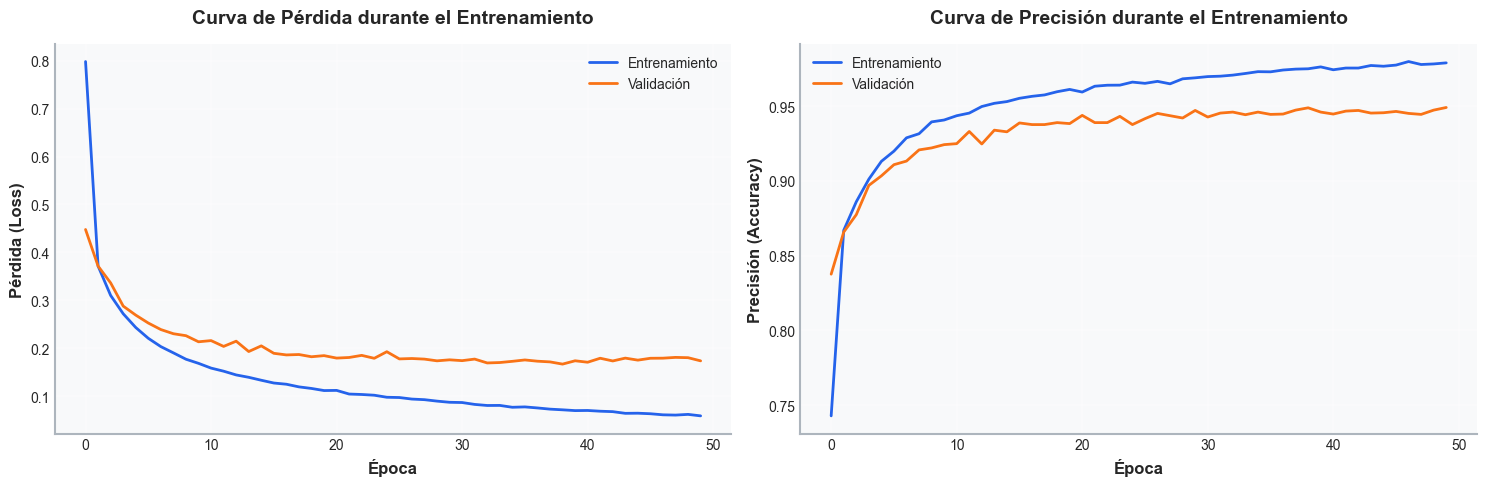


📊 MATRIZ DE CONFUSIÓN


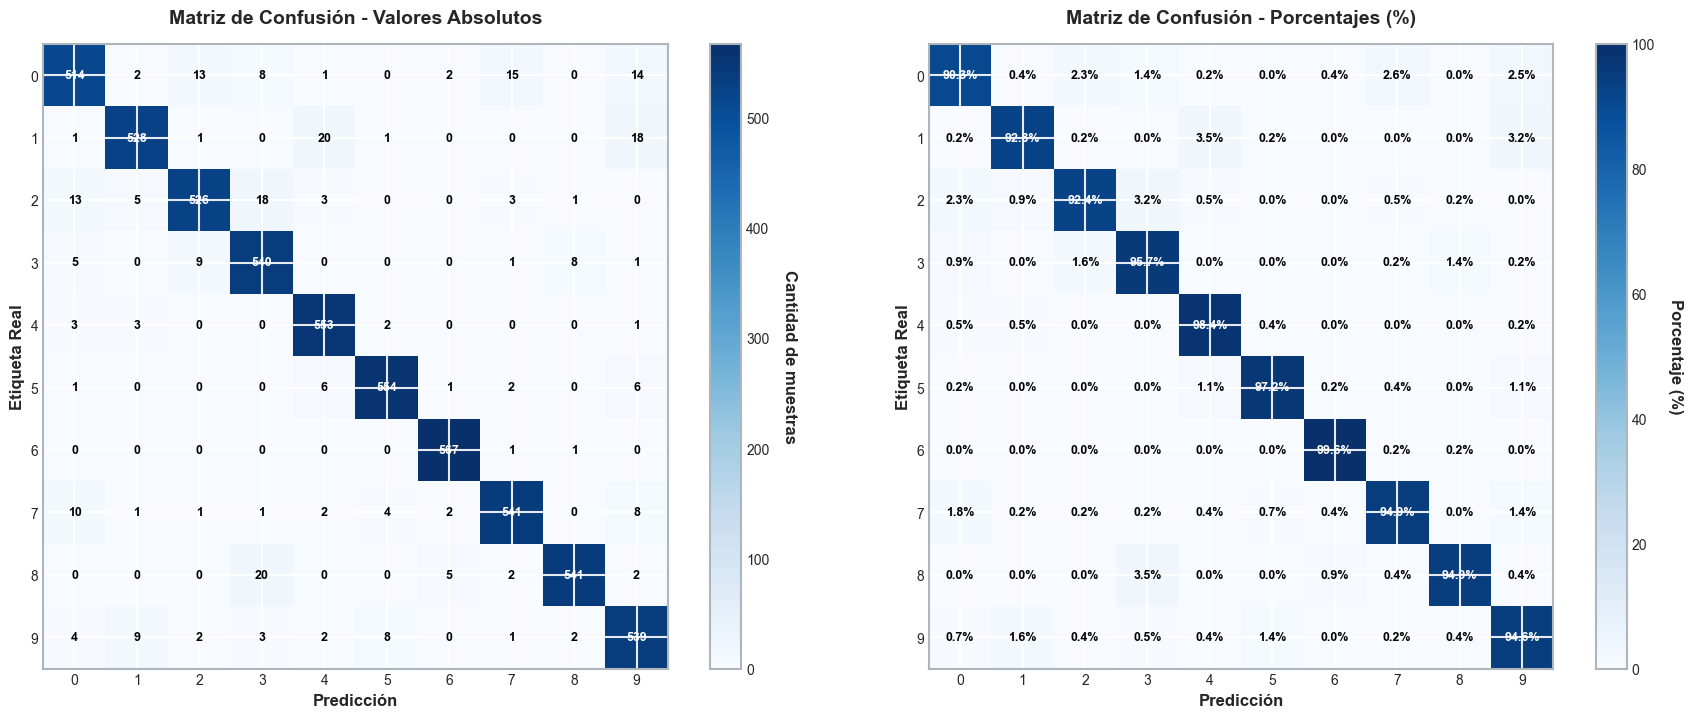


📄 Reporte de Clasificación:
              precision    recall  f1-score   support

           0     0.9328    0.9033    0.9179       569
           1     0.9635    0.9279    0.9454       569
           2     0.9529    0.9244    0.9384       569
           3     0.9153    0.9574    0.9359       564
           4     0.9421    0.9840    0.9626       562
           5     0.9736    0.9719    0.9728       570
           6     0.9827    0.9965    0.9895       569
           7     0.9558    0.9491    0.9525       570
           8     0.9783    0.9491    0.9635       570
           9     0.9151    0.9456    0.9301       570

    accuracy                         0.9509      5682
   macro avg     0.9512    0.9509    0.9509      5682
weighted avg     0.9513    0.9509    0.9509      5682


✅ Entrenamiento del modelo DL completado!


In [13]:
# Construir dataset (si no lo has hecho ya)
# eX, ey, df_info = build_dataset_from_folder(DATA_DIR, max_per_digit=None, sr=None)

# Parámetros de entrenamiento
EPOCHS = 50  # Número de épocas (iteraciones sobre todo el dataset)
BATCH_SIZE = 32  # Tamaño del lote (batch)
VALIDATION_SPLIT = 0.2  # 20% del train se usa para validación
TEST_SIZE = 0.2  # 20% para test final
RANDOM_STATE = 42

# Entrenar modelo DL
print("🧠 ENTRENANDO MODELO DE DEEP LEARNING")
print("="*80)
results_dl = train_dl_model(
    eX, ey,
    test_size=TEST_SIZE,
    validation_split=VALIDATION_SPLIT,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    random_state=RANDOM_STATE
)

# Visualizar curvas de entrenamiento
print("\n" + "="*80)
print("📈 CURVAS DE ENTRENAMIENTO")
print("="*80)
plot_training_curves(results_dl["history"])

# Visualizar matriz de confusión
print("\n" + "="*80)
print("📊 MATRIZ DE CONFUSIÓN")
print("="*80)
plot_confusion_matrix_dl(results_dl["y_test"], results_dl["y_pred"], "Deep Learning")

print("\n✅ Entrenamiento del modelo DL completado!")


## 🎲 Probar el modelo con un audio ALEATORIO
Ejecuta esta celda después de entrenar (`results`) para predecir un archivo del dataset al azar.


## 🎙️ Probar con tu micrófono (decir un número)
Esto grabará audio desde el micrófono por unos segundos, guardará un `.wav` temporal y lo clasificará con el modelo entrenado.


In [15]:

def predict_single_audio(audio_path: Path, results: dict, sr: Optional[int] = None) -> dict:
    """
    Predice el dígito de un archivo .wav usando el modelo entrenado (results).
    Muestra además visualizaciones del audio.
    """
    # Cargar modelo y scaler
    model = results["model"]
    scaler = results["scaler"]
    
    # Cargar audio
    y_sig, sr_sig = librosa.load(audio_path, sr=sr)
    feats = extract_feature_vector(y_sig, sr_sig)[None, :]  # (1, n_features)
    feats_s = scaler.transform(feats)
    pred_proba = model.predict(feats_s, verbose=0)
    pred = int(np.argmax(pred_proba, axis=1)[0])
    
    # Visualizaciones
    print(f"\n🎧 Archivo: {audio_path.name}")
    display(Audio(y_sig, rate=sr_sig))
    plot_waveform(y_sig, sr_sig, f"Forma de Onda - {audio_path.name}")
    plot_fft(y_sig, sr_sig, f"FFT - {audio_path.name}")
    plot_spectrogram(y_sig, sr_sig, f"Espectrograma - {audio_path.name}")
    
    return {"pred": pred, "sr": sr_sig}


def random_audio_from_data(data_dir: Path) -> Path:
    """
    Selecciona aleatoriamente un archivo .wav desde cualquier subcarpeta de data_dir.
    """
    subdirs = [d for d in data_dir.iterdir() if d.is_dir()]
    if not subdirs:
        raise RuntimeError("No hay subcarpetas en DATA_DIR")
    folder = random.choice(subdirs)
    wavs = list(folder.glob("*.wav"))
    # si la carpeta elegida está vacía, intenta otras al azar
    attempts = 0
    while not wavs and attempts < 10:
        folder = random.choice(subdirs)
        wavs = list(folder.glob("*.wav"))
        attempts += 1
    if not wavs:
        raise RuntimeError("No se encontraron .wav en las subcarpetas")
    return random.choice(wavs)


def record_microphone(seconds: float = 2.0, samplerate: int = 16000, channels: int = 1, out_path: Path = Path("mic_input.wav")) -> Path:
    """
    Graba audio desde el micrófono y lo guarda como WAV.
    - seconds: duración de la grabación
    - samplerate: frecuencia de muestreo (Hz)
    - channels: número de canales (1 = mono)
    """
    try:
        import sounddevice as sd
        import soundfile as sf
    except ImportError:
        raise ImportError("sounddevice no está instalado. Ejecuta: pip install sounddevice")
    
    print(f"🎙️ Grabando {seconds} s a {samplerate} Hz... (habla ahora)")
    audio = sd.rec(int(seconds * samplerate), samplerate=samplerate, channels=channels, dtype='float32')
    sd.wait()
    sf.write(str(out_path), audio, samplerate)
    print(f"💾 Guardado: {out_path}")
    return out_path


def predict_from_microphone(results: dict, seconds: float = 2.0, samplerate: int = 16000):
    """
    Graba audio desde el micrófono y realiza una predicción con el modelo entrenado.
    """
    tmp_path = record_microphone(seconds=seconds, samplerate=samplerate, channels=1)
    info = predict_single_audio(tmp_path, results, sr=None)
    print(f"\n🔎 Predicción del modelo: {info['pred']}")
    print("(Consejo: pronuncia un dígito claro en ingles: 0,1,2,3,4,5,6,7,8,9)")



🎧 Archivo: 4_31_45.wav


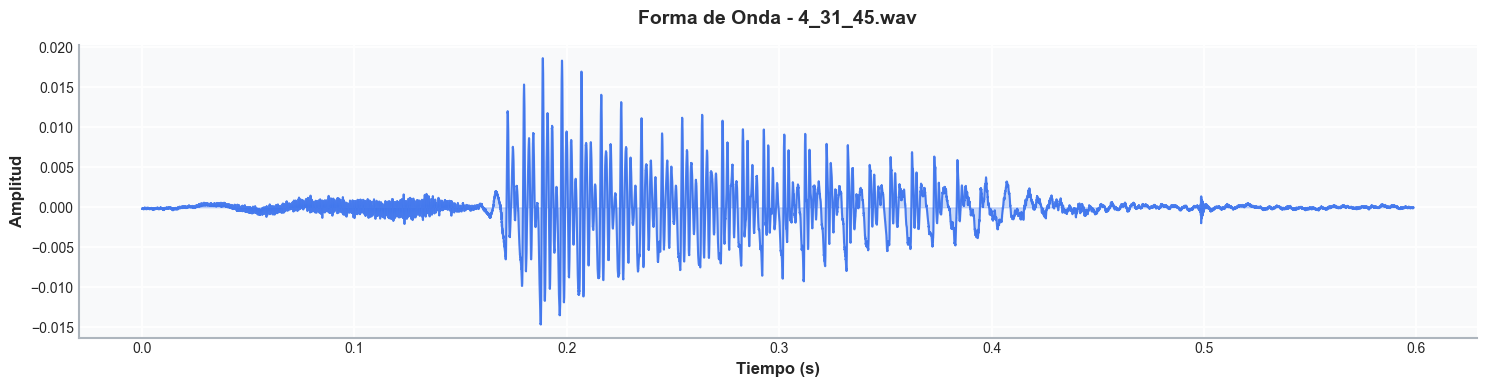

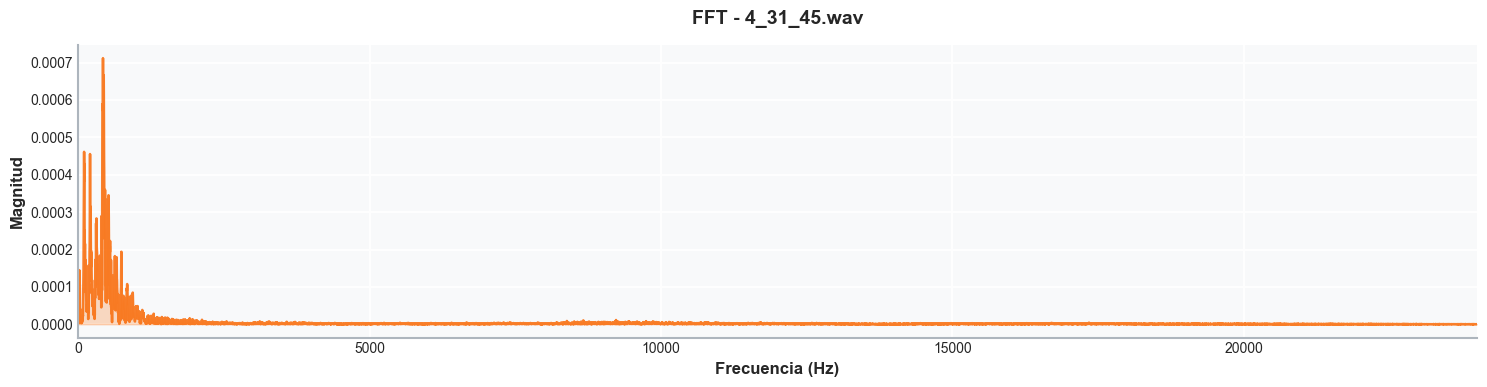

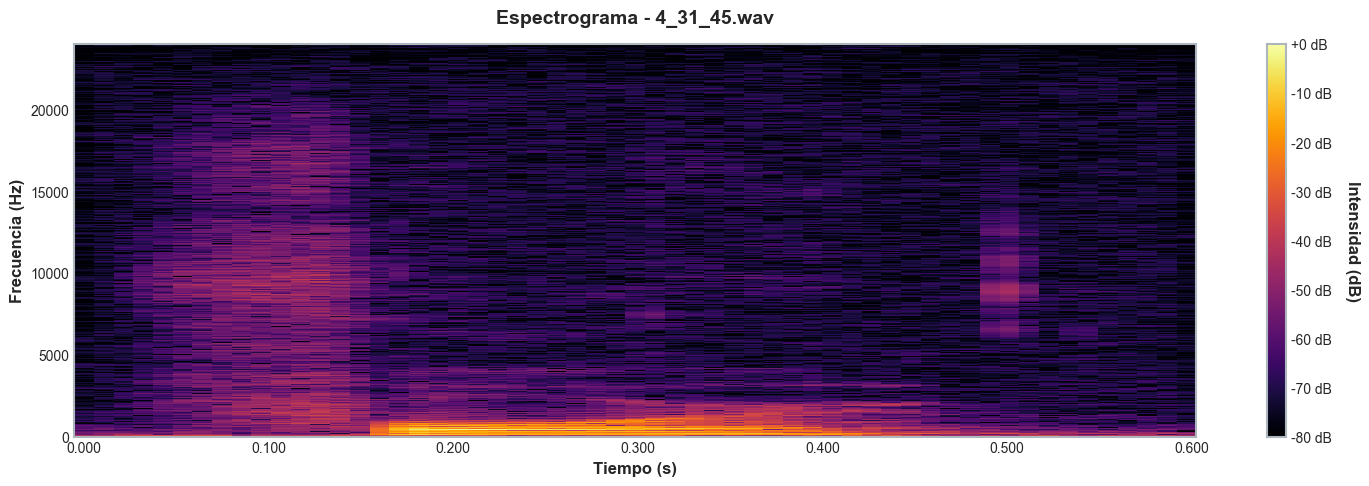


🔎 Predicción del modelo: 4
✅ Etiqueta real (desde nombre): 4
🎉 ¡Predicción correcta!


In [16]:
# 🎲 Probar con audio aleatorio del dataset
# Seleccionar audio aleatorio y predecir
rand_path = random_audio_from_data(DATA_DIR)
true_match = re.match(r"^(\d)_", rand_path.name)
true_digit = int(true_match.group(1)) if true_match else None

res = predict_single_audio(rand_path, results_dl, sr=None)
print(f"\n🔎 Predicción del modelo: {res['pred']}")
print(f"✅ Etiqueta real (desde nombre): {true_digit}")
if true_digit is not None:
    if res['pred'] == true_digit:
        print("🎉 ¡Predicción correcta!")
    else:
        print(f"❌ Predicción incorrecta")

In [ ]:
# 🎙️ Probar con micrófono (graba y predice)
# Ejemplo: grabar 2.5 s y predecir
predict_from_microphone(results_dl, seconds=2.5, samplerate=16000)